In [2]:
# Load trained model
import joblib
model = joblib.load("rf_model.pkl")




In [8]:
import numpy as np
import pandas as pd

# STEP 1: Define region bounds (Odisha approx.)
lat_min, lat_max = 18.0, 22.7
lon_min, lon_max = 81.5, 87.5
grid_resolution = 0.1  # ~10km

# STEP 2: Generate lat-lon grid
latitudes = np.arange(lat_min, lat_max, grid_resolution)
longitudes = np.arange(lon_min, lon_max, grid_resolution)
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

grid_points = pd.DataFrame({
    'lat': lat_grid.ravel(),
    'lon': lon_grid.ravel()
})

# STEP 3: Simulate AOD and Weather (placeholder)
np.random.seed(42)
grid_points['AOD'] = np.random.uniform(0.2, 0.8, len(grid_points))       # Simulated AOD
grid_points['Temp'] = np.random.uniform(295, 310, len(grid_points)) - 273.15  # Celsius
grid_points['RH'] = np.random.uniform(40, 90, len(grid_points))         # Relative Humidity
grid_points['U wind'] = np.random.uniform(-5, 5, len(grid_points))           # Wind u-component
grid_points['V wind'] = np.random.uniform(-5, 5, len(grid_points))           # Wind v-component
grid_points['PBL'] = np.random.uniform(500, 2000, len(grid_points))     # Boundary Layer Height

# STEP 4: Save to CSV
grid_points.to_csv("sample_odisha_grid.csv", index=False)


In [9]:
df_grid = pd.read_csv("sample_odisha_grid.csv")

# Fix column names to match training data
df_grid.rename(columns={
    'temp': 'Temp',
    'u': 'U wind',
    'v': 'V wind'
}, inplace=True)

# Select matching columns in correct order
X_grid = df_grid[['AOD', 'Temp', 'RH', 'U wind', 'V wind', 'PBL']]

# Predict
df_grid['PM2.5'] = model.predict(X_grid)

# Save predictions
df_grid.to_csv("odisha_pm25_prediction.csv", index=False)



In [10]:
import joblib
model = joblib.load("rf_model.pkl")

df_grid = pd.read_csv("sample_odisha_grid.csv")
X_grid = df_grid[['AOD', 'Temp', 'RH', 'U wind', 'V wind', 'PBL']]
df_grid['PM2.5'] = model.predict(X_grid)
df_grid.to_csv("odisha_pm25_prediction.csv", index=False)


In [11]:
import numpy as np

latitudes = sorted(df_grid['lat'].unique())
longitudes = sorted(df_grid['lon'].unique())

# Create 2D grid from predicted PM2.5
pm_grid = df_grid.pivot(index='lat', columns='lon', values='PM2.5')
pm_array = pm_grid.values[::-1]  # flip for correct orientation


In [13]:
import rasterio
from rasterio.transform import from_origin

transform = from_origin(west=min(longitudes), north=max(latitudes), xsize=0.1, ysize=0.1)

with rasterio.open(
    "pm25_map.tif", "w",
    driver="GTiff",
    height=pm_array.shape[0],
    width=pm_array.shape[1],
    count=1,
    dtype=pm_array.dtype,
    crs="EPSG:4326",
    transform=transform,
) as dst:
    dst.write(pm_array, 1)


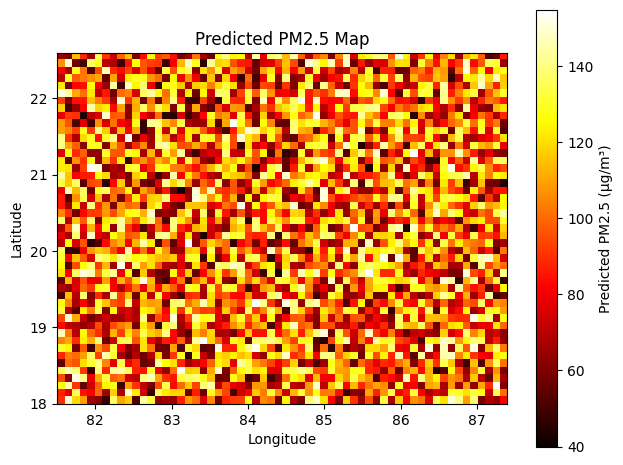

In [14]:
import matplotlib.pyplot as plt

plt.imshow(pm_array, cmap='hot', extent=[min(longitudes), max(longitudes), min(latitudes), max(latitudes)])
plt.colorbar(label='Predicted PM2.5 (µg/m³)')
plt.title("Predicted PM2.5 Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()
